# Week 9: Spatial data

In this part of today's session you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium


**Questions**: Outside of class, use [issue](https://github.com/abjer/tsds/issues) on GitHub for asking questions.

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely # https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

%matplotlib inline

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submoduele shapely.geometry has methods such as `Point`, `Polygon` and `MultiPolygon`

10.0 14.77032961426901 False True


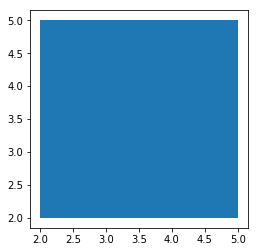

In [2]:
# [Answer to ex. 9.1.1 here]
square = Polygon([(2, 2), (5,2), (5, 5), (2,5)])
triangle = Polygon([(0,0), (4,0), (2,5)])
point1 = Point(2, 2)
point2 = Point(2.1, 2.1)
print(triangle.area, triangle.length, point1.within(square), point2.within(square))
geo = gpd.GeoSeries([square])
geo.plot()

> **Ex. 9.1.2** What is the spatial difference of square subtracted triangle? What is the union?

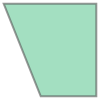

In [3]:
# [Answer to ex. 9.1.2 here]
square.difference(triangle)

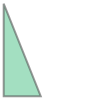

In [4]:
square.intersection(triangle)

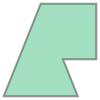

In [5]:
square.union(triangle)

> **Ex. 9.1.3** Make a GeoSeries of `square`, `triangle`. Plot the geoseries.

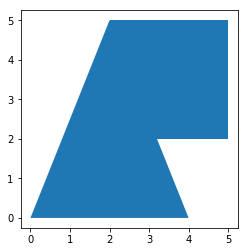

In [6]:
# [Answer to ex. 9.1.3 here]
geo = gpd.GeoSeries([square, triangle])
geo.plot()

### Part 9.2: Working with house sale prices

We have downloaded the shapes of the current Danish municipalities and parishes from [here](https://download.kortforsyningen.dk/content/danmarks-administrative-geografiske-inddeling-110000) for you. They are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data. 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of island etc. you can use the `unary_union` method for GeoSeries.

Use the script below to add regional information for municipalities.

In [7]:
kommuner = gpd.read_file('https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson')

kommuner = kommuner.to_crs('epsg:25832')
kommuner.columns = kommuner.columns.str.lower()

# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')



In [ ]:
# [Answer to ex. 9.2.1 here]


> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to select rows in the GeoDataFrame. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [13]:
# [Answer to ex. 9.2.2 here]

> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

In [14]:
# [Answer to ex. 9.2.3 here]

#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** We are now to construct a 500mx500m grid for Sealand:
- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. 
- For each of these points construct a square polygon assuming that the point is the south west corner of the square. 
- Select all the house sales that take place within the Sealand and nearby islands.

> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.

> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [15]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [20]:
# [Answer to ex. 9.2.4 here]

> **Ex. 9.2.5** Compute interpolation of house price for each grid cell as follows:
- Load the pre-structured data with house sales prices for the capital region of Denmark
- Make a loop over sale_year
    - Fit a nearest neighbor regression model to the square meter price (i.e. `price_area` for each year)
        - Set number of neighbors to 25 and radius to 25000
    - Apply the model to the grid data and assign as a column
- Plot the grid data for 2012

In [23]:
# [Answer to ex. 9.2.5 here]

### Part 9.3: Exploring OpenStreetMaps through interactive plotting

In this exercise we will play around with OpenStreetMaps (OSM) data. This exercise is short and exploratory but may serve as the beginning of a deeper analysis of features found in OpenStreetMaps. To get data we will use the overpass API made available in the function below.


In [24]:
from shapely.geometry import Point


overpass_base = "http://overpass-api.de/api/interpreter"

def query_overpass_gdf(tag, subtag='*', place='DK'):
    q = f"""
         [out:json];
         area["ISO3166-1"="{place}"][admin_level=2];
         (node["{tag}"="{subtag}"](area);
          way["{tag}"="{subtag}"](area);
          rel["{tag}"="{subtag}"](area);
         );
         out center;
         """
    response = requests.get(overpass_base, params={'data': q})    
    df = pd.DataFrame(response.json()['elements'])

    points = df[['lon','lat']].apply(Point, 1)
    gdf = gpd.GeoDataFrame(df,
                           geometry = points,
                           crs = {'init': 'epsg:4326'})

    gdf.to_crs(epsg=25832, inplace=True)
    
    return gdf

In [25]:
gdf_bar_dk = query_overpass_gdf('amenity', 'bar')

> **Ex. 9.3.1.** Select the rows that are in Sealand or surrounding isles (you can reuse your answer to 6.1.3). Note make sure that the CRS of the GeoDataFrames match.

In [26]:
# [Answer to ex. 9.3.1 here]

> **Ex. 9.3.2.** Make a folium plot of the bars in Sealand or nearby.

> *Hint:* the folium plugin called `FastMarkerCluster` can quickly plot many points. Note another folium plugin is called `MarkerCluster` and can plot points which have names. 

> You can use the below code to get you started with a plot beginning in Copenhagen:

>```
m = folium.Map(location=[55.7, 12.5],
               tiles='Stamen Toner',
               zoom_start=10)
```

In [28]:
# [Answer to ex. 9.3.2 here]